In [3]:
# !pip install scikit-image
# !pip install tensorflow

In [4]:
import cv2
import numpy as np
import os
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'cv2'

In [ ]:
# Paths to your datasets
MASKED_IMAGES_DIR = '/kaggle/input/dataset1/dataset/with_mask'
UNMASKED_IMAGES_DIR = '/kaggle/input/dataset1/dataset/without_mask'

In [ ]:
# Feature extraction using HOG and LBP
def extract_features(image):
    # Extract HOG features
    hog_features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                     block_norm='L2-Hys', transform_sqrt=True, feature_vector=True)
    
    return hog_features

In [ ]:
def extract_sift_descriptors(image):
    # Extract SIFT features
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is not None:
        # Flatten descriptors to fixed size using mean
        features = descriptors.mean(axis=0)
    else:
        # Return zeros if no descriptors are found (128-dimensional for SIFT)
        features = np.zeros(128)
    
    return features

In [ ]:
# Load dataset
def load_image_data(directory, label):
    feature_list = []
    label_list = []
    images = []
    
    for filename in os.listdir(directory):
        if filename.endswith(('jpg', 'png', 'jpeg')):
            image = cv2.imread(os.path.join(directory, filename))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (128, 128))
            images.append(image)
            feature_list.append(extract_features(image))
            label_list.append(label)
    
    return feature_list, label_list, images

In [ ]:
def build_model(hp):
    activation = hp.Choice("activation", ["relu", "leaky_relu"])  # Try different activation functions
    dropout_rate = hp.Float("dropout_rate", 0.2, 0.5, step=0.1)  # Vary dropout between 0.2 and 0.5
    learning_rate = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])  # Try different learning rates

    model = keras.Sequential([
        layers.Input(shape=(128, 128, 1)),

        # First Conv block
        layers.Conv2D(hp.Int("filters_1", 32, 64, step=16), (3, 3), activation=activation),
        layers.BatchNormalization(),
        layers.Conv2D(hp.Int("filters_2", 32, 64, step=16), (3, 3), activation=activation, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(dropout_rate),

        # Second Conv block
        layers.Conv2D(hp.Int("filters_3", 64, 128, step=32), (3, 3), activation=activation, padding='same'),
        layers.Conv2D(hp.Int("filters_4", 64, 128, step=32), (3, 3), activation=activation, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(dropout_rate),

        layers.Flatten(),
        layers.Dense(hp.Int("dense_units", 128, 512, step=128), activation=activation),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(2, activation='softmax')
    ])

    # Compile model with tunable learning rate
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Load data
masked_features, masked_labels, masked_images = load_image_data(MASKED_IMAGES_DIR, 1)
unmasked_features, unmasked_labels, unmasked_images = load_image_data(UNMASKED_IMAGES_DIR, 0)

In [ ]:
# Combine and split data
X = np.array(masked_features + unmasked_features)
y = np.array(masked_labels + unmasked_labels)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='rbf', C=2, gamma="scale")
svm_classifier.fit(X_train, y_train)
svm_predictions = svm_classifier.predict(X_test)

# Evaluate SVM
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM F1-Score:", f1_score(y_test, svm_predictions))



SVM Accuracy: 0.9388753056234719
SVM F1-Score: 0.9439461883408071


In [ ]:
# Train Logistic Regression classifier
logistic_classifier = LogisticRegression(max_iter=500, solver="liblinear", C=0.5, random_state=42)
logistic_classifier.fit(X_train, y_train)
logistic_predictions = logistic_classifier.predict(X_test)

# Evaluate Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, logistic_predictions))
print("Logistic Regression F1-Score:", f1_score(y_test, logistic_predictions))

Logistic Regression Accuracy: 0.902200488997555
Logistic Regression F1-Score: 0.9099099099099099


In [ ]:
# Train Neural Network classifier
neural_network = MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500, activation='relu', solver='adam', random_state=42)
neural_network.fit(X_train, y_train)
nn_predictions = neural_network.predict(X_test)

# Evaluate Neural Network
print("Neural Network Accuracy:", accuracy_score(y_test, nn_predictions))
print("Neural Network F1-Score:", f1_score(y_test, nn_predictions))

Neural Network Accuracy: 0.9437652811735942
Neural Network F1-Score: 0.9481981981981981


In [ ]:
X_cnn = np.array(masked_images + unmasked_images)
y_cnn = np.array(masked_labels + unmasked_labels)
y_cnn = to_categorical(y_cnn, num_classes=2)
# X_cnn = X_cnn / 255.0  # Normalize pixel values
X_cnn = np.expand_dims(X_cnn, axis=-1)  # Add channel dimension
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42)

tuner = kt.RandomSearch(build_model,
                        objective='val_accuracy',
                        max_trials=20,  # Set max trials
                        executions_per_trial=2,  # Run each config twice
                        directory='hyperparam_tuning',
                        project_name='cnn_tuning')


# Run the search for best hyperparameters
tuner.search(X_train_cnn, y_train_cnn, epochs=10, validation_data=(X_test_cnn, y_test_cnn))

# Get the best model and evaluate it
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)



Trial 20 Complete [00h 02m 40s]
val_accuracy: 0.9254278838634491

Best val_accuracy So Far: 0.95110023021698
Total elapsed time: 01h 02m 47s
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step - accuracy: 0.7857 - loss: 0.5752 - val_accuracy: 0.7971 - val_loss: 0.4694
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9154 - loss: 0.2243 - val_accuracy: 0.8399 - val_loss: 0.4812
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9610 - loss: 0.1249 - val_accuracy: 0.8007 - val_loss: 0.6318
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9743 - loss: 0.0803 - val_accuracy: 0.8435 - val_loss: 0.6659
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9804 - loss: 0.0608 - val_accuracy: 0.8313 - val_loss: 0.5689
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.9713 - loss: 0.0848 - val_accuracy: 0.9193 - val_loss: 0.2344
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9849 - loss: 0.0

In [ ]:
best_model.fit(X_train_cnn, y_train_cnn, epochs=10, validation_data=(X_test_cnn, y_test_cnn))
cnn_loss, cnn_accuracy = best_model.evaluate(X_test_cnn, y_test_cnn)
print(f"Best Model Accuracy: {cnn_accuracy}")

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9957 - loss: 0.0135 - val_accuracy: 0.9156 - val_loss: 0.3016
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9951 - loss: 0.0157 - val_accuracy: 0.9364 - val_loss: 0.2019
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9887 - loss: 0.0333 - val_accuracy: 0.9291 - val_loss: 0.2337
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.9975 - loss: 0.0150 - val_accuracy: 0.9144 - val_loss: 0.3313
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.9963 - loss: 0.0112 - val_accuracy: 0.9413 - val_loss: 0.2122
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9994 - loss: 0.0056 - val_accuracy: 0.9218 - val_loss: 0.2862
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9396 - loss: 0.1759 - val_accuracy: 0.7029 - val_loss: 1.0313
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9793 - loss: 0.0632 - val_accu

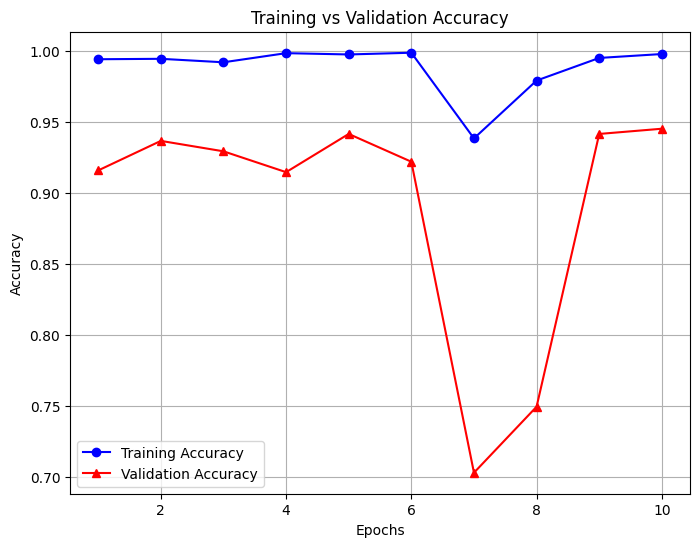

In [ ]:
history = best_model.fit(X_train_cnn, y_train_cnn, epochs=10, validation_data=(X_test_cnn, y_test_cnn))

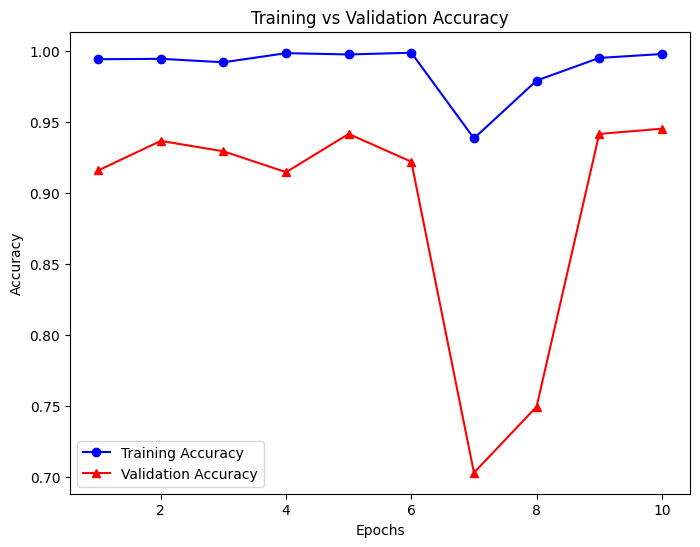

In [ ]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # 'bo-' means blue circles
plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')  # 'r^-' means red triangles
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

activation: relu
dropout_rate: 0.30000000000000004
learning_rate: 0.001
filters_1: 64
filters_2: 48
filters_3: 96
filters_4: 128
dense_units: 256


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


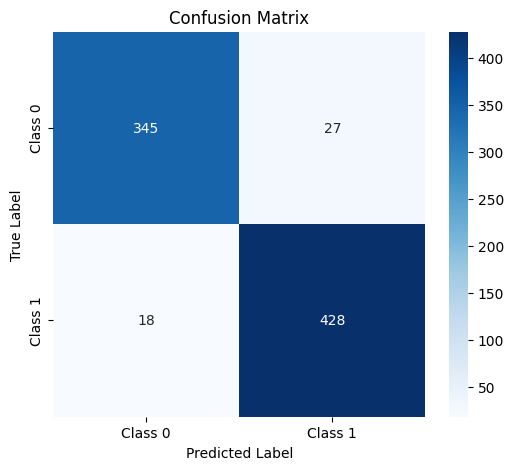

In [ ]:
y_pred = best_model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class labels
y_true = np.argmax(y_test_cnn, axis=1)  # Convert one-hot to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()